In [1]:
cd ..

/usr/local/google/home/ramasesh/Projects/rnn_dynamics


In [2]:
import functools
import jax.numpy as jnp
import os
import json
import numpy as np

import jax
from jax.experimental import optimizers
from src import data, model_utils
from renn.rnn import cells, unroll, network
from renn import utils
import renn

import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
%matplotlib inline

## Model and data loading

In [3]:
data_folder = 'results/yelp/2class/UGRNN_eta_0.01_L2_0.1_run_qusn3ty7/'

In [4]:
with open(os.path.join(data_folder, 'config.json')) as f:
    config = json.load(f)

### Get data

In [5]:
encoder, train_dset, test_dset = data.get_dataset(config['data'])

### Get model

In [6]:
def get_cell(cell_type, **kwargs):
    cell_functions = {'LSTM': cells.LSTM,
                      'GRU': cells.GRU,
                      'VanillaRNN': cells.VanillaRNN,
                      'UGRNN': cells.UGRNN}
    return cell_functions[cell_type](**kwargs)

In [7]:
cell = get_cell(config['model']['cell_type'],
                num_units=config['model']['num_units'])

AttributeError: module 'renn.rnn.cells' has no attribute 'UGRNN'

In [649]:
init_fun, apply_fun, emb_apply, readout_apply = network.build_rnn(encoder.vocab_size,
                                                                  config['model']['emb_size'],
                                                                  cell,
                                                                  num_outputs=config['model']['num_outputs'])
emb_init, emb_apply = renn.embedding(encoder.vocab_size, 
                                     config['model']['emb_size'])

In [631]:
network_params = model_utils.load_params(os.path.join(data_folder, 'final_params'))
emb_params, rnn_params, readout_params = network_params

In [632]:
optimizers.l2_norm(rnn_params)

DeviceArray(23.594744, dtype=float32)

### Verify that model performs as we expect on the test set

In [633]:
acc_fun = utils.make_acc_fun(apply_fun,
                             num_outputs = config['model']['num_outputs'])

In [634]:
# is_correct = []
# for batch in tfds.as_numpy(test_dset):
#     is_correct += [acc_fun(network_params, batch)]
# test_acc = np.mean(is_correct)
# print(f'Accuracy = {test_acc}')

## Analysis

### PCA of hidden states

In [635]:
from sklearn.decomposition import PCA

In [636]:
@jax.jit
def _get_all_states(inputs):
    rnn_inputs = emb_apply(emb_params, inputs)
    initial_states = cell.get_initial_state(rnn_params, batch_size=rnn_inputs.shape[0])
    return renn.unroll_rnn(initial_states, rnn_inputs, functools.partial(cell.batch_apply, rnn_params))

def rnn_states(batch):
    states = _get_all_states(batch['inputs'])
    return [h[:idx] for h, idx in zip(states, batch['index'])]

def rnn_end_states(batch):
    states = rnn_states(batch)
    return [h[-1] for h in states]

In [637]:
test_batch = next(tfds.as_numpy(test_dset))

hs = rnn_states(test_batch)
end_states = rnn_end_states(test_batch)
pts = np.vstack(hs)[::2]
pts.shape

(19366, 512)

In [638]:
states_by_value = {k: [h for h, lbl in zip(hs, test_batch['labels']) if lbl == k] for k in range(config['data']['num_classes'])}
end_states_by_value = {k: [h for h, lbl in zip(end_states, test_batch['labels']) if lbl == k] for k in range(config['data']['num_classes'])}

In [639]:
pca = PCA()
pca.fit(pts)

pca_end = PCA()
pca_end.fit(np.vstack(end_states))

PCA()

In [640]:
var_ratio = pca.explained_variance_ratio_
var_ratio = np.cumsum(var_ratio)

var_ratio_end = pca_end.explained_variance_ratio_
var_ratio_end = np.cumsum(var_ratio_end)

Text(0.5, 1.0, 'L2 = 0.01')

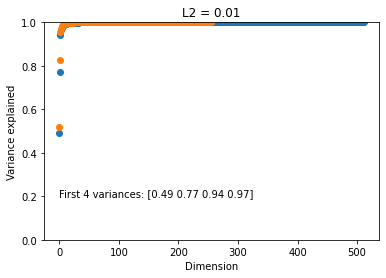

In [641]:
plt.scatter(range(len(var_ratio)), var_ratio)
plt.scatter(range(len(var_ratio_end)), var_ratio_end)
plt.xlabel('Dimension')
plt.ylabel('Variance explained')
plt.ylim(0,1)
plt.text(00, 0.2, f'First 4 variances: {np.round(var_ratio[:4],2)}');

L2 = config['optim']['L2']
plt.title(f'L2 = {L2}')

### Visualizing the hidden states projected into 2D PCA plane

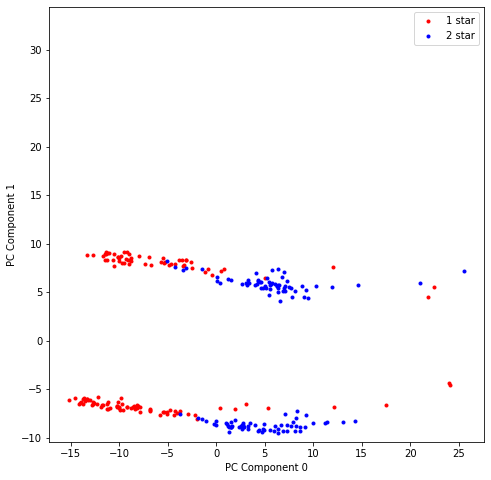

In [642]:
plt.figure(figsize=(8,8))

dim_0 = 0
dim_1 = 1

colors = ['red', 'blue', 'green']

for k in range(config['data']['num_classes']):
    transformed = pca.transform(np.vstack(end_states_by_value[k])).T
    x = transformed[dim_0]
    y = transformed[dim_1]

    plt.scatter(x, y, marker='.', label=f'{k+1} star', color=colors[k])
    
#     transformed = pca.transform(np.vstack(states_by_value[k])).T
#     x = transformed[dim_0]
#     y = transformed[dim_1]
#     plt.scatter(x, y, alpha=0.01, color=colors[k])

# readout_weight = readout_params[0]
# x_ro = transformed_readout[dim_0]
# y_ro = transformed_readout[dim_1]

# for i in range(len(x_ro)):
#     plt.plot([0, x_ro[i]], [0, y_ro[i]])
    
plt.xlabel(f'PC Component {dim_0}')          
plt.ylabel(f'PC Component {dim_1}')
plt.axis('square')
plt.legend(loc='upper right')

### Visualize the final states in the 2D plane

### Find the fixed points

In [622]:
fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)

In [623]:
FIXED_POINT_TOLERANCE = 1e-5

fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, 
                                                            pts,
                                                            jnp.zeros((pts.shape[0], config['model']['emb_size'])),
                                                            optimizers.adam(0.01),
                                                            tolerance=FIXED_POINT_TOLERANCE)

100%|██████████| 10000/10000 [01:08<00:00, 146.83it/s]


Text(0, 0.5, 'Fixed point loss')

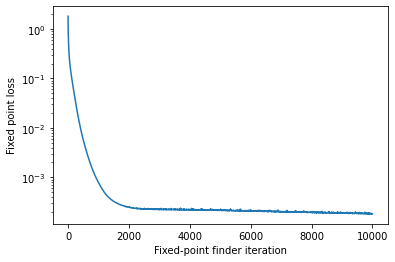

In [624]:
plt.semilogy(loss_hist)
plt.xlabel('Fixed-point finder iteration')
plt.ylabel('Fixed point loss')

Text(0, 0.5, 'Projection onto principal component #2')

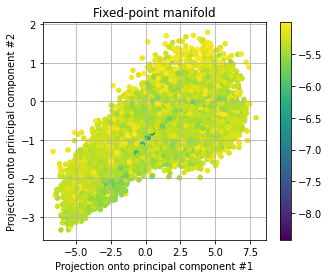

In [580]:
plt.figure(figsize=(5, 4))

THRESHOLD = 1e-5

transformed_fp = pca.transform(fixed_points).T
x = transformed_fp[dim_0]
y = transformed_fp[dim_1]

mask = fp_losses < THRESHOLD

x = x[mask]
y = y[mask]

plt.scatter(x, y, s=20, c=np.log10(fp_losses[mask]))
# plt.xlim(-8, 8)
# plt.ylim(-8, 8)
plt.grid()

plt.title('Fixed-point manifold')

plt.colorbar()

plt.xlabel('Projection onto principal component #1')
plt.ylabel('Projection onto principal component #2')

#### Dimensionality of the fixed point manifold

In [581]:
fp_pca = PCA()
fp_pca.fit(fixed_points)

PCA()

(0.0, 10.0)

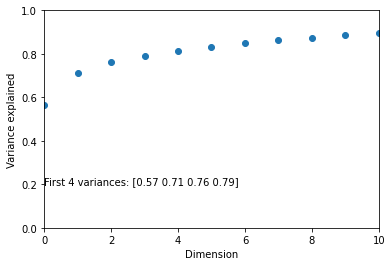

In [582]:
fp_var_ratio = fp_pca.explained_variance_ratio_
fp_var_ratio = np.cumsum(fp_var_ratio)

plt.scatter(range(len(fp_var_ratio)), fp_var_ratio)
plt.xlabel('Dimension')
plt.ylabel('Variance explained')
plt.ylim(0,1)
plt.text(00, 0.2, f'First 4 variances: {np.round(fp_var_ratio[:4],2)}');
plt.xlim(0,10)

In [583]:
transformed_readout= pca.transform(readout_weight.T).T

In [584]:
readout_weight = readout_params[0]
transformed_readout= pca.transform(readout_weight.T).T

### Check alignment of the fixed point PCA vectors with the hidden state PCA vectors

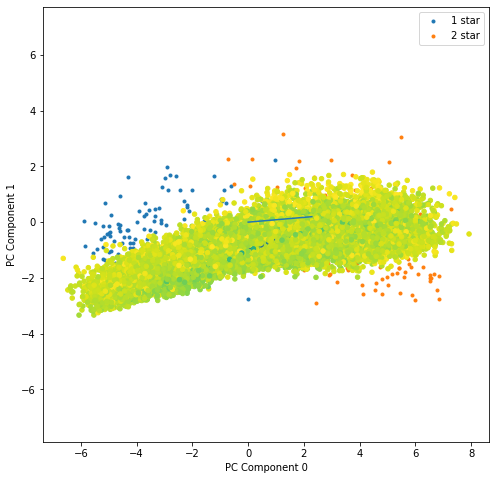

In [585]:
plt.figure(figsize=(8,8))

dim_0 = 0
dim_1 = 1

for k in range(config['data']['num_classes']):
    transformed = pca.transform(np.vstack(end_states_by_value[k])).T
    x = transformed[dim_0]
    y = transformed[dim_1]

    plt.scatter(x, y, marker='.', label=f'{k+1} star')

transformed_fp = pca.transform(fixed_points).T
x = transformed_fp[dim_0]
y = transformed_fp[dim_1]

mask = fp_losses < THRESHOLD

x = x[mask]
y = y[mask]

plt.scatter(x, y, s=20, c=np.log10(fp_losses[mask]))
    
readout_weight = readout_params[0]
transformed_readout= pca.transform(readout_weight.T).T
x_ro = transformed_readout[dim_0]
y_ro = transformed_readout[dim_1]

for i in range(len(x_ro)):
    plt.plot([0, x_ro[i]], [0, y_ro[i]])
    
plt.xlabel(f'PC Component {dim_0}')          
plt.ylabel(f'PC Component {dim_1}')
plt.axis('equal')
plt.legend(loc='upper right')

To check:
Using the sklearn PCA projection, it computes the mean and uses that mean in the transform.  For the fixed points that shouldn't be a problem, but the readout weights could definitely be affected.  